In [1]:
import parse_data.prepare_data as prepare_data
import parse_data.flip_rotate_trajectories as flip_rotate_trajectories
from analysis.response_times import calculate_response_times, plot_response_times
import data_extraction.get_indices as get_indices
import globals
from plotting import plot_octagon, plot_trajectory
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Polygon
from matplotlib import colors
import math
import analysis.loser_inferred_choice as loser_inferred_choice
import seaborn as sns
import data_strings


In [2]:
data_folder = data_strings.DATA_FOLDER
json_filenames_all_social = data_strings.JSON_FILENAMES_SOCIAL
json_filenames_all_solo = data_strings.JSON_FILENAMES_SOLO

In [3]:
json_filenames = json_filenames_all_social

In [4]:
# prepare the session dataframe and dataframes of each individual trial
df, trial_list = prepare_data.prepare_data(data_folder, json_filenames, combine=True)

filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\first_experiments_2409\240913\2024-09-13_11-31-00_YansuJerrySocial.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\second_experiments_2409\240927\2024-09-27_14-25-20_SaraEmilySocial.json
Loading complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\third_experiments_2410\241017\2024-10-17_14-28-40_ShamirAbigailSocial.json
Loading complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\fourth_experiments_2410\241017\2024-10-17_16-41-38_ZimoElsaSocial.json
Loading complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\fifth_experiments_241112\2024-11-12_13-31-14_KhadijaWendySocial.json
Loading complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\sixth_experiments_241112\2024-11-12_15-23-24_FrancescaSenSzeSocial.json
Loading complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\seventh_experiments_241113\2024-11-

In [5]:
get_indices.get_trials_with_wall_sep(trial_list=trial_list, wall_sep=1).size

422

In [6]:
## HEATMAPS ##

In [7]:
x_min = -20
x_max = 20
y_min = -20
y_max = 20

In [8]:
def heatmap_counts_from_location_data(location_array, n_rows=10, n_cols=10, x_min=x_min, x_max=x_max, 
                                      y_min=y_min, y_max=y_max):
    ''' Produce a matrix of counts across spatial location from n*2 location data '''

    # define a grid of counts
    grid_width = (x_max - x_min)/n_cols
    grid_height = (y_max - y_min)/n_rows
    grid = np.zeros([n_rows, n_cols])

    # Create a matrix of heatmap counts based on which bin starting location fits into
    for i in range(len(location_array[:,0])):
        x_val = location_array[i,0]
        y_val = location_array[i,1]
        x_bin = int((x_val - x_min)/grid_width)
        y_bin = int((y_val - y_min)/grid_height)

        if 0 <= y_bin < n_rows and 0 <= x_bin < n_cols:
            grid[y_bin, x_bin] += 1

    return grid

In [9]:
def plot_heatmap_from_count_array(ax, count_array, x_min=x_min, x_max=x_max, 
                                      y_min=y_min, y_max=y_max, vmin=None, vmax=None):

    # get the zipped coordinate list of octagon x and y vertex points
    octagon_vertex_coordinates = plot_octagon.return_octagon_path_points()

    if vmin is None:
        # display heatmap, covering the full graph
        im = ax.imshow(count_array, extent=[x_min, x_max, y_min, y_max],
                   origin='lower', cmap='plasma')

    else:
        # display heatmap, covering the full graph
        im = ax.imshow(count_array, extent=[x_min, x_max, y_min, y_max],
                   origin='lower', cmap='plasma', vmin=0, vmax=1)  
    
    # a matplotlib Artist with an edge and face colour
    patch = Polygon(octagon_vertex_coordinates, edgecolor='black', facecolor='none', lw=2)
    

    ax.add_patch(patch)         # make octagon outline visible
    im.set_clip_path(patch)     # crop image to coordinates inside the outline
    
    # Set aspect ratio to be square
    ax.set_aspect(1.)
    
    plt.colorbar(im)

    # ax.set_title("Count heatmap of winner location at the start of each trial")

    
    # # Loop over data dimensions and create text annotations.
    # coordinates = np.arange(x_min, x_max, count_array.shape[0])
    # for i in range(coordinates.size):
    #     for j in range(coordinates.size):
    #         text = ax.text(coordinates[j]+2.22, coordinates[i]+2.22, count_array[i, j],
    #                        ha="center", va="center", color="k")
    
    # give some white border to the graph
    ax.set_xlim([-22,22])
    ax.set_ylim([-22,22])


    print("total counts by location:\n", count_array)

    return ax

In [10]:
def plot_heatmap_from_count_array_sns(ax, count_array, bin_counts, x_min=x_min, x_max=x_max, 
                                      y_min=y_min, y_max=y_max, vmin=None, vmax=None):
    ''' Heatmap annotated with bin counts, no longer plotted over the octagon shape '''
    
    # probability data
    heatmap_data = count_array
    
    # count data
    annotation_data = bin_counts 

    # flip the y-axis
    heatmap_data = np.flipud(heatmap_data)
    annotation_data = np.flipud(bin_counts)
    
    # set up the x and y ranges for labeling bins from -20 to +20
    x_bins = np.linspace(-20, 20, 9)
    y_bins = np.linspace(-20, 20, 9)
    
    # create the heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(heatmap_data, annot=annotation_data, fmt=".0f", cmap="plasma", 
                     xticklabels=np.round(x_bins, 2), yticklabels=np.round(y_bins, 2),
                     vmin=0, vmax=1, # colourbar range
                     cbar_kws={'label': 'Heatmap Intensity'}, ax=ax)



    # get the zipped coordinate list of octagon x and y vertex points
    octagon_vertex_coordinates = plot_octagon.return_octagon_path_points()

    # a matplotlib Artist with an edge and face colour
    patch = Polygon(octagon_vertex_coordinates, edgecolor='black', facecolor='none', lw=2)
    

    ax.add_patch(patch)         # make octagon outline visible
    
    # Set labels
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_title("Heatmap with Separate Annotation Values")
    
    plt.show()

In [11]:
def winner_start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=None,
                             chosen_wall=None):
    ''' Plot a heatmap of the winner's location in the arena when the walls are
        revealed. This is done for all trials with a given wall separation, and 
        flipped and rotated to put WALL_1 at 0 degrees and WALL_2 at 45 
        degrees '''
    
    # filter trials for a wall separation of wall_sep
    trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=wall_sep) # verified correct indices
    print(f"number of trials with wall_sep {wall_sep} is: {trial_indices.size}")
    
    # further filter by HighLow trial type if specified
    if trial_type:
        trial_type_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
        trial_indices = np.intersect1d(trial_indices, trial_type_indices)
        print(f"number of trials with trial_type {trial_type} is: {trial_indices.size}")

    # further filter by chose High if specified
    if chosen_wall:
        chose_wall_trial_indices = get_indices.get_trials_chose_wall(trial_list, chosen_wall=chosen_wall)
        trial_indices = np.intersect1d(trial_indices, chose_wall_trial_indices)
        print(f"number of trials with chosen_wall {chosen_wall} is: {trial_indices.size}")
        
    trial_list_filtered = [trial_list[i] for i in trial_indices] # just list comp
    
    # flip and rotate the relevant trials for WALL_1 and WALL_2 to be walls 1 and 2
    flip_rotated_trials = []
    for i in range(len(trial_list_filtered)):
        flip_rotated_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_filtered, trial_index=i)) 
    
    # get the ID of the player who ended the trial, for each trial
    trigger_activators_slice_onset_loc = get_indices.get_trigger_activators_slice_onset_loc(flip_rotated_trials)
    trigger_activators_slice_onset_loc = np.asarray(trigger_activators_slice_onset_loc)
    
    # generate heat map data and plot
    count_array = heatmap_counts_from_location_data(trigger_activators_slice_onset_loc)
    print(f"number of trials in count_array is: {np.sum(count_array)}")
    ax = plot_octagon.plot_octagon()
    plot_heatmap_from_count_array(ax, count_array)

    return ax

In [12]:
def loser_start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=None,
                             chosen_wall=None):
    ''' Plot a heatmap of the loser's location in the arena when the walls are
        revealed. This is done for all trials with a given wall separation, and 
        flipped and rotated to put WALL_1 at 0 degrees and WALL_2 at 45 
        degrees '''
    
    # filter trials for a wall separation of wall_sep
    trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=wall_sep) # verified correct indices
    
    # further filter by HighLow trial type if specified
    if trial_type:
        trial_type_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
        trial_indices = np.intersect1d(trial_indices, trial_type_indices)

    # further filter by chose High if specified
    if chosen_wall:
        chose_wall_trial_indices = get_indices.get_trials_chose_wall(trial_list, chosen_wall=chosen_wall)
        trial_indices = np.intersect1d(trial_indices, chose_wall_trial_indices)
        
    trial_list_filtered = [trial_list[i] for i in trial_indices] # just list comp
    
    # flip and rotate the relevant trials for WALL_1 and WALL_2 to be walls 1 and 2
    flip_rotated_trials = []
    for i in range(len(trial_list_filtered)):
        flip_rotated_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_filtered, trial_index=i)) 
    
    # get the ID of the player who ended the trial, for each trial
    trigger_activators = get_indices.get_trigger_activators(trial_list)
    loser_ids = 1 - trigger_activators # if the winner was 1, loser_id is 0, and vice versa
    losers_slice_onset_loc = get_indices.get_player_slice_onset_locs(flip_rotated_trials, player_id_list=loser_ids)
    losers_slice_onset_loc = np.asarray(losers_slice_onset_loc)
    
    # generate heat map data and plot
    count_array = heatmap_counts_from_location_data(losers_slice_onset_loc)
    ax = plot_octagon.plot_octagon()
    plot_heatmap_from_count_array(ax, count_array)

    return ax

In [13]:
def start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=None,
                             chosen_wall=None):
    ''' Plot a heatmap of both players location in the arena when the walls are
    revealed. This is done for all trials with a given wall separation, and 
    flipped and rotated to put WALL_1 at 0 degrees and WALL_2 at 45 
    degrees '''
    
    # filter trials for a wall separation of wall_sep
    trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=wall_sep) # verified correct indices
    
    # further filter by HighLow trial type if specified
    if trial_type:
        trial_type_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
        trial_indices = np.intersect1d(trial_indices, trial_type_indices)
    
    # further filter by chose High if specified
    if chosen_wall:
        chose_wall_trial_indices = get_indices.get_trials_chose_wall(trial_list, chosen_wall=chosen_wall)
        trial_indices = np.intersect1d(trial_indices, chose_wall_trial_indices)
        
    trial_list_filtered = [trial_list[i] for i in trial_indices] # just list comp
    
    # flip and rotate the relevant trials for WALL_1 and WALL_2 to be walls 1 and 2
    flip_rotated_trials = []
    for i in range(len(trial_list_filtered)):
        flip_rotated_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_filtered, trial_index=i)) 
    
    # get the positions of both players for each trial, and include both
    print(f" flip_rotate_trials len: {len(flip_rotated_trials)}")
    player_0_slice_onset_loc = get_indices.get_player_slice_onset_locs(flip_rotated_trials, player_id_list=np.zeros(len(flip_rotated_trials)))
    player_0_slice_onset_loc = np.asarray(player_0_slice_onset_loc)
    print(f"player_0_slice_onset_loc shape = {player_0_slice_onset_loc.shape}")
    
    player_1_slice_onset_loc = get_indices.get_player_slice_onset_locs(flip_rotated_trials, player_id_list=np.ones(len(flip_rotated_trials)))
    player_1_slice_onset_loc = np.asarray(player_1_slice_onset_loc)

    slice_onset_locs = np.vstack([player_0_slice_onset_loc, player_1_slice_onset_loc])
    # generate heat map data and plot
    count_array = heatmap_counts_from_location_data(slice_onset_locs)
    ax = plot_octagon.plot_octagon()
    plot_heatmap_from_count_array(ax, count_array)
    
    return ax

In [14]:
def probability_chose_wall_location_heatmap(trial_list, wall_sep=1,
                                            trial_type=None,
                                            chosen_wall=globals.WALL_1,
                                            include_inferred_choice=True,
                                            bincounts=False):
    ''' Plot a heatmap of the probability of choosing a specific wall against the chooser's slice onset location
        This can be restricted by: trial type, wall separation'''

    ## FILTERING -----------------
    
    # filter trials for a wall separation of wall_sep
    trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=wall_sep) # verified correct indices
    
    # further filter by trial type if specified
    if trial_type:
        trial_type_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
        trial_indices = np.intersect1d(trial_indices, trial_type_indices)
    
    # further filter by chosen wall
    chose_wall_trial_indices = get_indices.get_trials_chose_wall(trial_list, chosen_wall=chosen_wall)
    chose_wall_trial_indices = np.intersect1d(trial_indices, chose_wall_trial_indices)

    ## -----------------------
    
    # filter the trials lists by these indices
    trial_list_filtered = [trial_list[i] for i in trial_indices] # just list comp
    trial_list_filtered_chose_wall = [trial_list[i] for i in chose_wall_trial_indices] 

    ## FIND FLIPPED LOCATIONS -----------------------
    
    # flip and rotate the relevant trials for WALL_1 and WALL_2 to be walls 1 and 2
    flip_rotated_trials = []
    for i in range(len(trial_list_filtered)):
        flip_rotated_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_filtered, trial_index=i)) 
    flip_rotated_trials_chose_wall = []
    for i in range(len(trial_list_filtered_chose_wall)):
        flip_rotated_trials_chose_wall.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_filtered_chose_wall, trial_index=i)) 
    
    # get the ID of the player who ended the trial, for each trial
    # then get this player's location. This makes up the actual-choice data
    trigger_activators_slice_onset_loc = get_indices.get_trigger_activators_slice_onset_loc(flip_rotated_trials)
    trigger_activators_slice_onset_loc = np.asarray(trigger_activators_slice_onset_loc)
    trigger_activators_slice_onset_loc_chose_wall = get_indices.get_trigger_activators_slice_onset_loc(flip_rotated_trials_chose_wall)
    trigger_activators_slice_onset_loc_chose_wall = np.asarray(trigger_activators_slice_onset_loc_chose_wall)

    ## -----------------------

    ## INFERRED CHOICE ----------------------------
    
    # if we are including inferred choice we want another two trial lists: relevant trials where inferred choice was confident, 
    # and relevant trials where inferred choice was confident and the choice was relevant
    # These will be the 2 arrays we use to find the probability for each location
    if include_inferred_choice:
        # identify inferred choice for all trials in session
        (loser_inferred_choice_wall_num,
        loser_inferred_choice_confidence) = loser_inferred_choice.infer_loser_choice_session(trial_list) # get inferred choices

        ## FILTERING -------------------
        
        # loop through each relevant trial index and identify if the loser's choice was confident
        trial_indices_inferred_choice_confident = []
        for trial_idx in trial_indices:
            if loser_inferred_choice_confidence[trial_idx] == True:
                trial_indices_inferred_choice_confident.append(trial_idx)

        print(f"trial_indices_inferred_choice_confident: {len(trial_indices_inferred_choice_confident)}")
        
        # loop through each relevant trial index and identify if the loser's choice was confident and the relevant wall
        trial_indices_inferred_choice_confident_and_relevant = []
        for trial_idx in trial_indices:
            # get the relevant wall number
            this_trial = trial_list[trial_idx]
            this_trial_walls = get_indices.get_walls(this_trial)
            relevant_wall_num = this_trial_walls[0] if chosen_wall == globals.WALL_1 else this_trial_walls[1]
            
            if loser_inferred_choice_confidence[trial_idx] == True and loser_inferred_choice_wall_num[trial_idx] == relevant_wall_num:
                trial_indices_inferred_choice_confident_and_relevant.append(trial_idx)

        print(f"trial_indices_inferred_choice_confident_and_relevant: {len(trial_indices_inferred_choice_confident_and_relevant)}")

        
        ## -------------------------------

        # filter the trials lists by these indices
        trial_list_filtered_inferred_choice_confident = [trial_list[i] for i in trial_indices_inferred_choice_confident] # just list comp
        trial_list_filtered_chose_wall_inferred_choice_confident = [trial_list[i] for i in trial_indices_inferred_choice_confident_and_relevant] 

        print(f"len trial_list_filtered_inferred_choice_confident = {len(trial_list_filtered_inferred_choice_confident)}")
        print(f"len trial_list_filtered_chose_wall_inferred_choice_confident = {len(trial_list_filtered_chose_wall_inferred_choice_confident)}")


        ## FIND FLIPPED LOCATIONS -----------------------

        # flip and rotate the relevant trials for WALL_1 and WALL_2 to be walls 1 and 2
        flip_rotated_trials_inferred_choice_confident = []
        for i in range(len(trial_list_filtered_inferred_choice_confident)):
            flip_rotated_trials_inferred_choice_confident.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_filtered_inferred_choice_confident,
                                                                                                                   trial_index=i)) 
        flip_rotated_trials_chose_wall_inferred_choice_confident = []
        for i in range(len(trial_list_filtered_chose_wall_inferred_choice_confident)):
            flip_rotated_trials_chose_wall_inferred_choice_confident.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_filtered_chose_wall_inferred_choice_confident,
                                                                                                                              trial_index=i)) 
        print(f"len flip_rotated_trials_inferred_choice_confident = {len(flip_rotated_trials_inferred_choice_confident)}")
        print(f"len flip_rotated_trials_chose_wall_inferred_choice_confident = {len(flip_rotated_trials_chose_wall_inferred_choice_confident)}")


        
        
        loser_slice_onset_loc = np.zeros([2,len(trial_list_filtered_inferred_choice_confident)])
        for i in range(len(trial_list_filtered_inferred_choice_confident)):
            
            this_trial = flip_rotated_trials_inferred_choice_confident[i]
            
            # identify loser id
            winner_id = get_indices.get_trigger_activator(this_trial)
            loser_id = 1 if winner_id == 0 else 0

            # loser location
            (loser_x_loc_slice_onset, 
             loser_y_loc_slice_onset) = get_indices.get_player_slice_onset_loc(this_trial, loser_id)

            loser_slice_onset_loc[:,i] = [loser_x_loc_slice_onset, loser_y_loc_slice_onset]
        
        loser_slice_onset_loc_chose_wall = np.zeros([2,len(trial_list_filtered_chose_wall_inferred_choice_confident)])
        for i in range(len(trial_list_filtered_chose_wall_inferred_choice_confident)):
            
            this_trial = flip_rotated_trials_chose_wall_inferred_choice_confident[i]
            
            # identify loser id
            winner_id = get_indices.get_trigger_activator(this_trial)
            loser_id = 1 if winner_id == 0 else 0

            # loser location
            (loser_x_loc_slice_onset, 
             loser_y_loc_slice_onset) = get_indices.get_player_slice_onset_loc(this_trial, loser_id)

            loser_slice_onset_loc_chose_wall[:,i] = [loser_x_loc_slice_onset, loser_y_loc_slice_onset]

        print(f" shape[1] of loser_slice_onset_loc = {loser_slice_onset_loc.shape[1]}")  
        print(f" shape[1] of loser_slice_onset_loc_chose_wall = {loser_slice_onset_loc_chose_wall.shape[1]}")

        print(f" loser_slice_onset_loc: {loser_slice_onset_loc[:,30:40]}")
        print(f" loser_slice_onset_loc: {loser_slice_onset_loc_chose_wall[:,30:40]}") 

        ## --------------------------

        ## COUNT ARRAYS --------------------------
        count_array_inferred_choice_confident = heatmap_counts_from_location_data(loser_slice_onset_loc.T, n_rows=9, n_cols=9)
        count_array_inferred_choice_confident_chose_wall = heatmap_counts_from_location_data(loser_slice_onset_loc_chose_wall.T, n_rows=9, n_cols=9)


        print("total inferred_choice trial counts by location:\n", count_array_inferred_choice_confident)
        print("chose inferred_choice relevant_wall counts by location:\n", count_array_inferred_choice_confident_chose_wall)

        ## -----------------------

    ## -------------------- END INFERRED CHOICE

           
            

    
    # get counts by location for all trials and for winner-chose-wall trials
    count_array = heatmap_counts_from_location_data(trigger_activators_slice_onset_loc, n_rows=9, n_cols=9)
    count_array_chose_wall = heatmap_counts_from_location_data(trigger_activators_slice_onset_loc_chose_wall, n_rows=9, n_cols=9)

    print("total trial counts by location:\n", count_array)
    print("chose wall counts by location:\n", count_array_chose_wall)

    ## IF INFERRED CHOICE, ADD THE INFERRED CHOICE COUNT ARRAYS TO THE STANDARD ONES
    if include_inferred_choice:
        count_array = count_array + count_array_inferred_choice_confident
        count_array_chose_wall = count_array_chose_wall + count_array_inferred_choice_confident_chose_wall

    # element-wise division, avoiding division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        probability_count_array = np.divide(count_array_chose_wall, count_array)
        probability_count_array[count_array == 0] = np.nan  # Set divisions by zero to NaN

    # remove bins with too few trials
    probability_count_array[count_array < 4] = np.nan  
    
    ax = plot_octagon.plot_octagon()
    if bincounts:
        plot_heatmap_from_count_array_sns(ax, probability_count_array, count_array, vmin=0, vmax=1)
    else:
        plot_heatmap_from_count_array(ax, probability_count_array, vmin=0, vmax=1)

    return ax

 flip_rotate_trials len: 341
player_0_slice_onset_loc shape = (341, 2)
total counts by location:
 [[ 0.  0.  0.  0.  3.  1.  0.  0.  0.  0.]
 [ 0.  1.  1.  2.  3.  2.  5.  0.  1.  0.]
 [ 0.  3.  1.  3.  5.  5.  4.  4.  2.  0.]
 [ 3.  2.  2. 15. 18. 16.  2.  4.  2.  2.]
 [ 1.  3.  5. 21. 78. 84. 21.  2.  3.  4.]
 [ 4.  3.  7. 24. 86. 74. 18.  4.  1.  1.]
 [ 1.  2.  1.  7. 15. 17. 18.  7.  2.  1.]
 [ 0.  1.  2.  8.  4.  9.  4.  0.  2.  0.]
 [ 0.  2.  3.  3.  2.  4.  1.  3.  1.  0.]
 [ 0.  0.  0.  1.  2.  3.  0.  0.  0.  0.]]


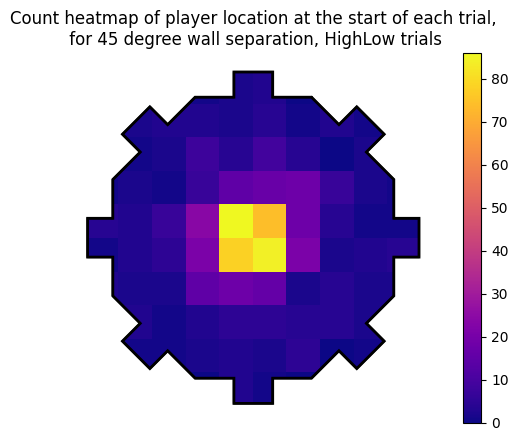

In [15]:
ax = start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=None)
ax.set_title("Count heatmap of player location at the start of each trial,\n for 45 degree wall separation, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

number of trials with wall_sep 1 is: 422
number of trials with trial_type HighLow is: 341
number of trials in count_array is: 341.0
total counts by location:
 [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  2.  1.  1.  0.  0.  0.]
 [ 2.  1.  2.  3.  8.  6.  1.  1.  1.  1.]
 [ 0.  2.  1.  9. 33. 43.  7.  2.  2.  3.]
 [ 1.  2.  6. 11. 40. 39. 13.  3.  0.  1.]
 [ 0.  1.  1.  6. 12. 12. 14.  4.  0.  1.]
 [ 0.  1.  0.  6.  4.  6.  4.  0.  1.  0.]
 [ 0.  2.  1.  1.  1.  1.  1.  3.  1.  0.]
 [ 0.  0.  0.  1.  1.  3.  0.  0.  0.  0.]]


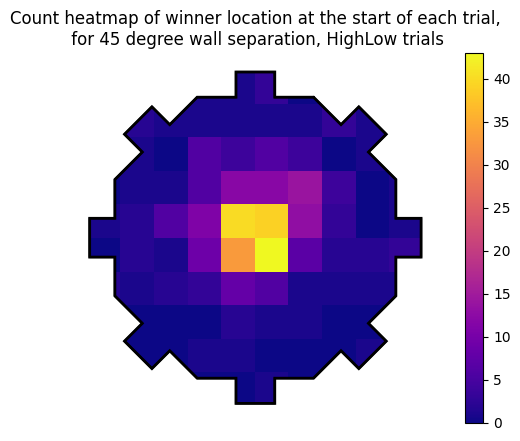

In [16]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=None)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

number of trials with wall_sep 2 is: 265
number of trials with trial_type HighLow is: 204
number of trials in count_array is: 204.0
total counts by location:
 [[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  3.  8.  0.  2.  0.  0.]
 [ 1.  0.  2.  8. 22. 18.  5.  3.  0.  0.]
 [ 1.  2.  2. 10. 26. 32.  8.  1.  0.  1.]
 [ 0.  0.  1.  0.  4.  6.  4.  0.  5.  0.]
 [ 0.  0.  2.  1.  1.  2.  2.  0.  1.  0.]
 [ 0.  0.  1.  1.  1.  3.  1.  1.  2.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  0.  0.  0.]]


Text(0.5, 1.0, 'Count heatmap of winner location at the start of each trial,\n for 90 degree wall separation, HighLow trials')

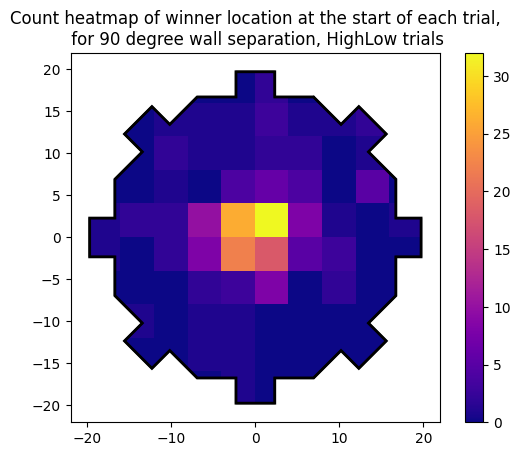

In [17]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=2,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=None)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 90 degree wall separation, HighLow trials")

number of trials with wall_sep 4 is: 304
number of trials with trial_type HighLow is: 237
number of trials in count_array is: 237.0
total counts by location:
 [[ 0.  0.  0.  1.  0.  2.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  1.  2.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  2.  3.  0.  1.  2.  0.]
 [ 1.  1.  0.  4.  2. 13.  3.  2.  0.  0.]
 [ 0.  0.  2.  7. 24. 32.  3.  0.  0.  2.]
 [ 1.  1.  2.  6. 34. 32. 13.  1.  1.  0.]
 [ 0.  1.  1.  5.  5.  9.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  3.  2.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]


Text(0.5, 1.0, 'Count heatmap of winner location at the start of each trial,\n for 180 degree wall separation, HighLow trials')

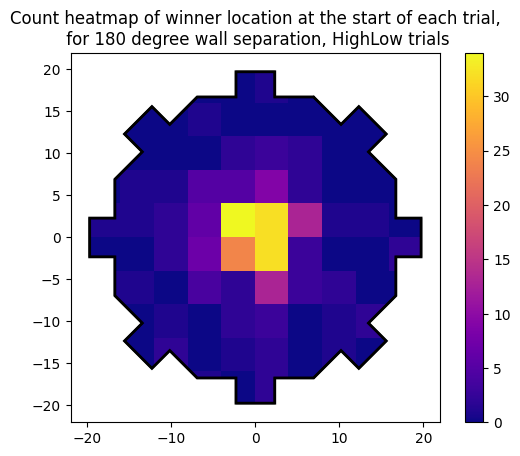

In [18]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=4,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=None)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 180 degree wall separation, HighLow trials")

number of trials with wall_sep 1 is: 422
number of trials with trial_type HighLow is: 341
number of trials with chosen_wall data.wall1 is: 287
number of trials in count_array is: 287.0
total counts by location:
 [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  1.  1.  0.  0.  0.]
 [ 2.  1.  1.  2.  6.  6.  1.  0.  0.  1.]
 [ 0.  1.  1.  8. 30. 38.  4.  1.  2.  3.]
 [ 1.  2.  6. 10. 37. 32.  9.  2.  0.  1.]
 [ 0.  1.  1.  6. 10.  9. 10.  2.  0.  1.]
 [ 0.  1.  0.  6.  4.  5.  2.  0.  0.  0.]
 [ 0.  2.  1.  1.  1.  0.  1.  3.  0.  0.]
 [ 0.  0.  0.  1.  1.  3.  0.  0.  0.  0.]]


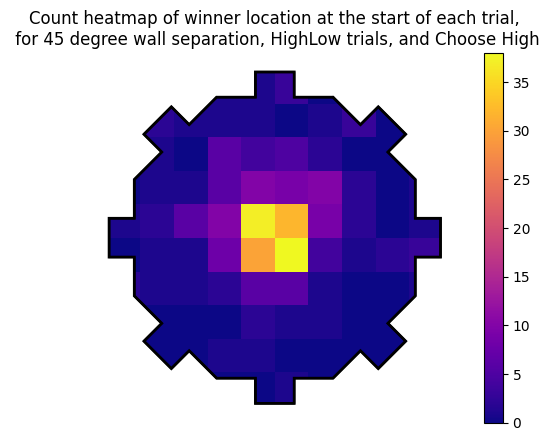

In [19]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=globals.WALL_1)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation, HighLow trials, and Choose High")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

number of trials with wall_sep 1 is: 422
number of trials with trial_type HighLow is: 341
number of trials with chosen_wall data.wall2 is: 54
number of trials in count_array is: 54.0
total counts by location:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 2. 0. 0. 1. 1. 0.]
 [0. 1. 0. 1. 3. 5. 3. 1. 0. 0.]
 [0. 0. 0. 1. 3. 7. 4. 1. 0. 0.]
 [0. 0. 0. 0. 2. 3. 4. 2. 0. 0.]
 [0. 0. 0. 0. 0. 1. 2. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Text(0.5, 1.0, 'Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation, HighLow trials, and Choose Low')

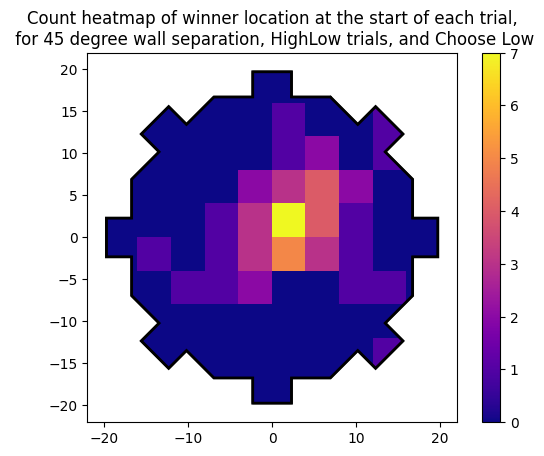

In [20]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=globals.WALL_2)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation, HighLow trials, and Choose Low")

number of trials with wall_sep 2 is: 265
number of trials with trial_type HighLow is: 204
number of trials with chosen_wall data.wall1 is: 132
number of trials in count_array is: 132.0
total counts by location:
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  3.  2.  0.  1.  0.  0.]
 [ 1.  0.  2.  7. 13. 16.  3.  0.  0.  0.]
 [ 1.  2.  1.  8. 18. 15.  5.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.  5.  2.  0.  4.  0.]
 [ 0.  0.  2.  1.  1.  1.  1.  0.  0.  0.]
 [ 0.  0.  1.  1.  1.  2.  0.  1.  2.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]


Text(0.5, 1.0, 'Count heatmap of winner location at the start of each trial,\n for 90 degree wall separation, HighLow trials, and Choose High')

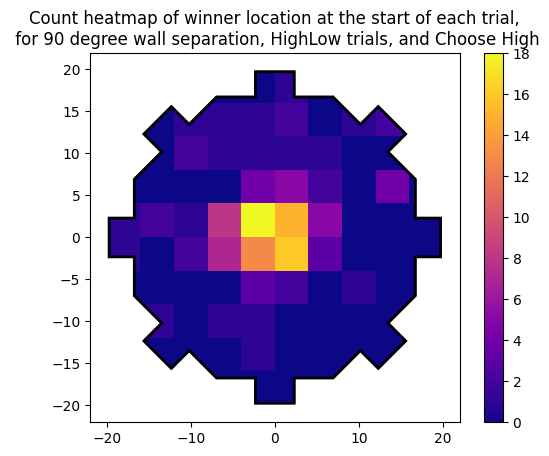

In [21]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=2,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=globals.WALL_1)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 90 degree wall separation, HighLow trials, and Choose High")

number of trials with wall_sep 4 is: 304
number of trials with trial_type HighLow is: 237
number of trials with chosen_wall data.wall1 is: 138
number of trials in count_array is: 138.0
total counts by location:
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  1.  0.  0.  1.  0.  0.]
 [ 1.  1.  0.  2.  0.  3.  2.  0.  0.  0.]
 [ 0.  0.  1.  5. 19. 18.  0.  0.  0.  0.]
 [ 1.  1.  2.  3. 25. 17.  5.  1.  1.  0.]
 [ 0.  1.  1.  4.  4.  7.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  3.  2.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]


Text(0.5, 1.0, 'Count heatmap of winner location at the start of each trial,\n for 180 degree wall separation, HighLow trials, and Choose High')

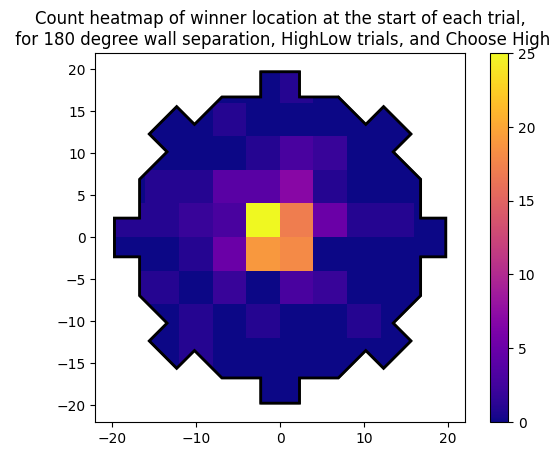

In [22]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=4,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=globals.WALL_1)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 180 degree wall separation, HighLow trials, and Choose High")

total counts by location:
 [[ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  1.  2.  0.  1.  0.]
 [ 0.  2.  0.  1.  4.  4.  2.  2.  1.  0.]
 [ 1.  1.  1.  7. 11.  7.  2.  1.  1.  1.]
 [ 1.  2.  3.  7. 36. 44. 12.  0.  2.  2.]
 [ 1.  2.  4. 12. 40. 37. 12.  1.  0.  1.]
 [ 1.  1.  1.  5.  5. 11.  9.  6.  2.  1.]
 [ 0.  1.  0.  4.  1.  5.  1.  0.  0.  0.]
 [ 0.  1.  1.  2.  1.  0.  1.  3.  1.  0.]
 [ 0.  0.  0.  1.  1.  0.  0.  0.  0.  0.]]


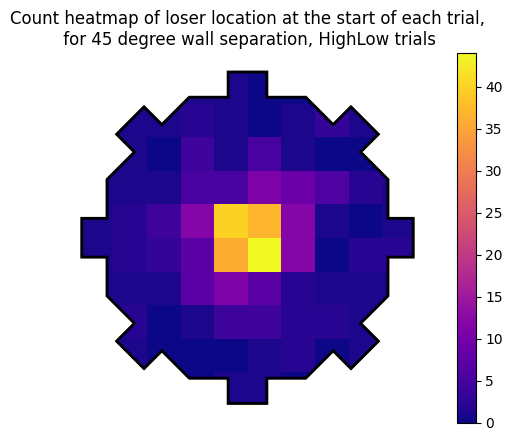

In [23]:
ax = loser_start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=globals.HIGH_LOW)
ax.set_title("Count heatmap of loser location at the start of each trial,\n for 45 degree wall separation, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

total counts by location:
 [[ 0.  0.  0.  0.  1.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  1.  0.  1.  1.  0.  0.]
 [ 0.  4.  0.  2.  2.  2.  0.  0.  0.  0.]
 [ 1.  0.  1.  4.  4.  9.  2.  2.  0.  0.]
 [ 2.  1.  1.  6. 25. 27.  5.  3.  1.  0.]
 [ 1.  1.  2.  6. 23. 23.  2.  1.  0.  1.]
 [ 0.  1.  2.  3.  3.  4.  2.  0.  4.  0.]
 [ 0.  0.  1.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  2.  3.  1.  0.  3.  0.]
 [ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.]]


Text(0.5, 1.0, 'Count heatmap of loser location at the start of each trial,\n for 90 degree wall separation, HighLow trials')

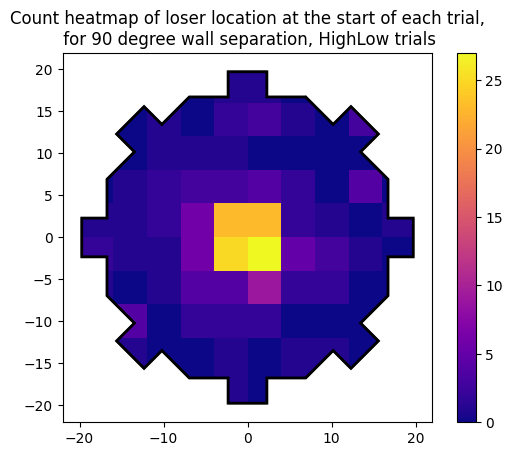

In [24]:
ax = loser_start_loc_heatmap(trial_list, wall_sep=2,
                             trial_type=globals.HIGH_LOW)
ax.set_title("Count heatmap of loser location at the start of each trial,\n for 90 degree wall separation, HighLow trials")

total counts by location:
 [[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  0.]
 [ 0.  1.  1.  2.  3.  3.  0.  0.  1.  0.]
 [ 2.  2.  1.  3.  5.  7.  5.  1.  2.  0.]
 [ 0.  0.  4. 10. 28. 26.  3.  1.  0.  2.]
 [ 0.  2.  3.  4. 37. 34.  9.  2.  1.  0.]
 [ 0.  1.  2.  5.  3.  6.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  2.  3.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


Text(0.5, 1.0, 'Count heatmap of loser location at the start of each trial,\n for 180 degree wall separation, HighLow trials')

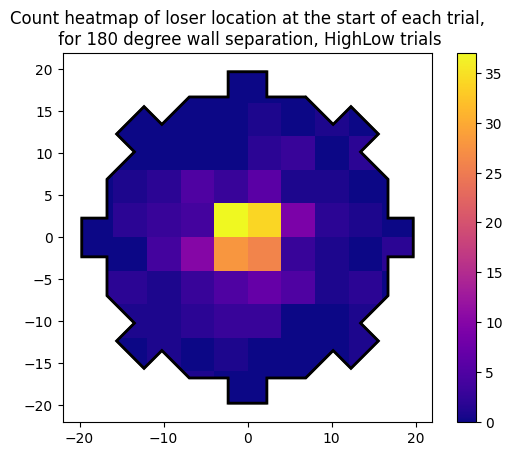

In [25]:
ax = loser_start_loc_heatmap(trial_list, wall_sep=4,
                             trial_type=globals.HIGH_LOW)
ax.set_title("Count heatmap of loser location at the start of each trial,\n for 180 degree wall separation, HighLow trials")

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:319: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:45: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:146: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


trial_indices_inferred_choice_confident: 232
trial_indices_inferred_choice_confident_and_relevant: 122
len trial_list_filtered_inferred_choice_confident = 232
len trial_list_filtered_chose_wall_inferred_choice_confident = 122
len flip_rotated_trials_inferred_choice_confident = 232
len flip_rotated_trials_chose_wall_inferred_choice_confident = 122
 shape[1] of loser_slice_onset_loc = 232
 shape[1] of loser_slice_onset_loc_chose_wall = 122
 loser_slice_onset_loc: [[-7.47357607 -3.5747797  -2.28244686 -0.10315787 -7.04695375  8.1440164
  -4.93045062  4.17218351  3.69731975 -1.77336837]
 [ 0.01618282 -9.26623348 -1.35215425 -2.32706061 -3.61645653 -7.3733311
  -8.84029777 -3.87177825  1.88329566 -1.21641779]]
 loser_slice_onset_loc: [[ -3.4745698   -2.03281871  -5.92106677  -0.46396094   8.02685583
   -3.14447069  -2.14923286   5.53347731  -5.0106248   -0.1055558 ]
 [ -3.92560959  -3.841313    -9.53207995  -5.969245   -11.18909005
   -2.9934864    1.12519073  -2.70453739  -3.55226545 -17.7

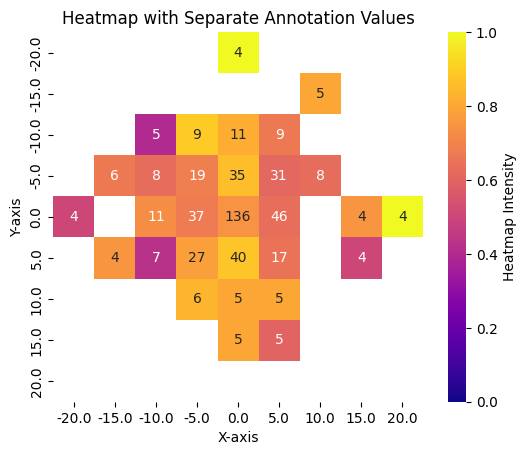

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Probability of choose High across locations at the start of each trial,\n for 45 degree wall separation')

In [28]:
ax = probability_chose_wall_location_heatmap(trial_list, wall_sep=1,
                                                        trial_type=globals.HIGH_LOW,
                                                        chosen_wall=globals.WALL_1,
                                                        include_inferred_choice=True,
                                                        bincounts=True)
ax.set_title("Probability of choose High across locations at the start of each trial,\n for 45 degree wall separation")

trial_indices_inferred_choice_confident: 232
trial_indices_inferred_choice_confident_and_relevant: 71
len trial_list_filtered_inferred_choice_confident = 232
len trial_list_filtered_chose_wall_inferred_choice_confident = 71
len flip_rotated_trials_inferred_choice_confident = 232
len flip_rotated_trials_chose_wall_inferred_choice_confident = 71
 shape[1] of loser_slice_onset_loc = 232
 shape[1] of loser_slice_onset_loc_chose_wall = 71
 loser_slice_onset_loc: [[-7.47357607 -3.5747797  -2.28244686 -0.10315787 -7.04695375  8.1440164
  -4.93045062  4.17218351  3.69731975 -1.77336837]
 [ 0.01618282 -9.26623348 -1.35215425 -2.32706061 -3.61645653 -7.3733311
  -8.84029777 -3.87177825  1.88329566 -1.21641779]]
 loser_slice_onset_loc: [[ -1.05554867   1.48824538  -1.35583812   2.86997806  -4.71317603
  -10.6165214   -8.54767338  -5.07495513  -0.24214831  -3.79121633]
 [  0.37604171   1.7629841   -1.33463377  -3.5911763    0.97970467
   -2.86759335  -9.99269966  -8.93261133 -15.50401402   1.35376

Text(0.5, 1.0, 'Probability heatmap of choose Low across locations at the start of each trial,\n for 45 degree wall separation, HighLow trials')

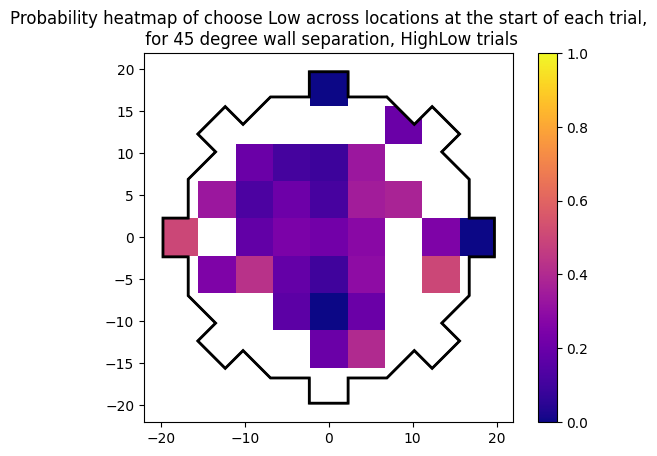

In [27]:
ax = probability_chose_wall_location_heatmap(trial_list, wall_sep=1,
                                            trial_type=globals.HIGH_LOW,
                                            chosen_wall=globals.WALL_2)
ax.set_title("Probability heatmap of choose Low across locations at the start of each trial,\n for 45 degree wall separation, HighLow trials")